## Importation de la base de l'INSEE sur la distribution des revenus

In [2]:
!pip install pynsee
from pynsee.download import download_file

filosofi = download_file("FILOSOFI_DEC_ARR_ENS")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 KB 3.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 2.1 MB/s eta 0:00:00m eta 0:00:010:00:01


/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
Downloading: 100%|█████████████████████████| 21.8M/21.8M [01:07<00:00, 337kiB/s]
Extracting: 100%|███████████████████████████| 22.3M/22.3M [00:00<00:00, 203MB/s]


In [3]:
import requests
import zipfile
import os
url = "https://www.insee.fr/fr/statistiques/fichier/4291712/indic-struct-distrib-revenu-2017-COMMUNES.zip"
dest_zip = "baseInsee.zip"
response = requests.get(url)
if response.status_code == 200:
    with open(dest_zip, "wb") as f:
        f.write(response.content)
    print("Téléchargement réussi : fichier sauvegardé sous", dest_zip)
else:
    print("Erreur lors du téléchargement :", response.status_code)
    exit()

destination_dir = "./data/insee"
os.makedirs(destination_dir, exist_ok=True) 
print("Décompression du fichier...")
with zipfile.ZipFile(dest_zip, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)
print(f"Décompression terminée dans le dossier : {destination_dir}")
print("Lecture des fichiers dans le répertoire décompressé :")
for root, dirs, files in os.walk(destination_dir):
    for file in files:
        print(f"- {file}")

Téléchargement réussi : fichier sauvegardé sous baseInsee.zip
Décompression du fichier...
Décompression terminée dans le dossier : ./data/insee
Lecture des fichiers dans le répertoire décompressé :
- FILO2017_TRDECILES_DEC_COM.xlsx
- FILO2017_DEC_Pauvres_COM.xlsx
- FILO2017_DISP_Pauvres_COM.xlsx
- FILO2017_TRDECILES_DISP_COM.xlsx
- FILO2017_DEC_COM.xlsx
- FILO2017_DISP_COM.xlsx


In [24]:
import pandas as pd

file_path = destination_dir + "/FILO2017_DISP_Pauvres_COM.xlsx"
df_pauv = pd.read_excel(file_path, sheet_name="ENSEMBLE",header=5)
df_pauv_flt = df_pauv[df_pauv['CODGEO'].isin([f"{i:05d}" for i in range(75101, 75121)])]
df_pauv_flt = df_pauv_flt.rename(columns={
    'CODGEO': 'INSEE_COG',
})
df_pauv_flt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 3321 to 3340
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INSEE_COG  20 non-null     object 
 1   LIBGEO     20 non-null     object 
 2   TP4017     20 non-null     float64
 3   TP5017     20 non-null     float64
 4   TP6017     20 non-null     float64
 5   TP60Q217   20 non-null     int64  
 6   TP60IP17   20 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ KB


## Statistiques descriptives

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_21078/1613870552.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='LIBGEO', y='TP6017', data=df_pauv_sorted, palette='RdYlGn_r')


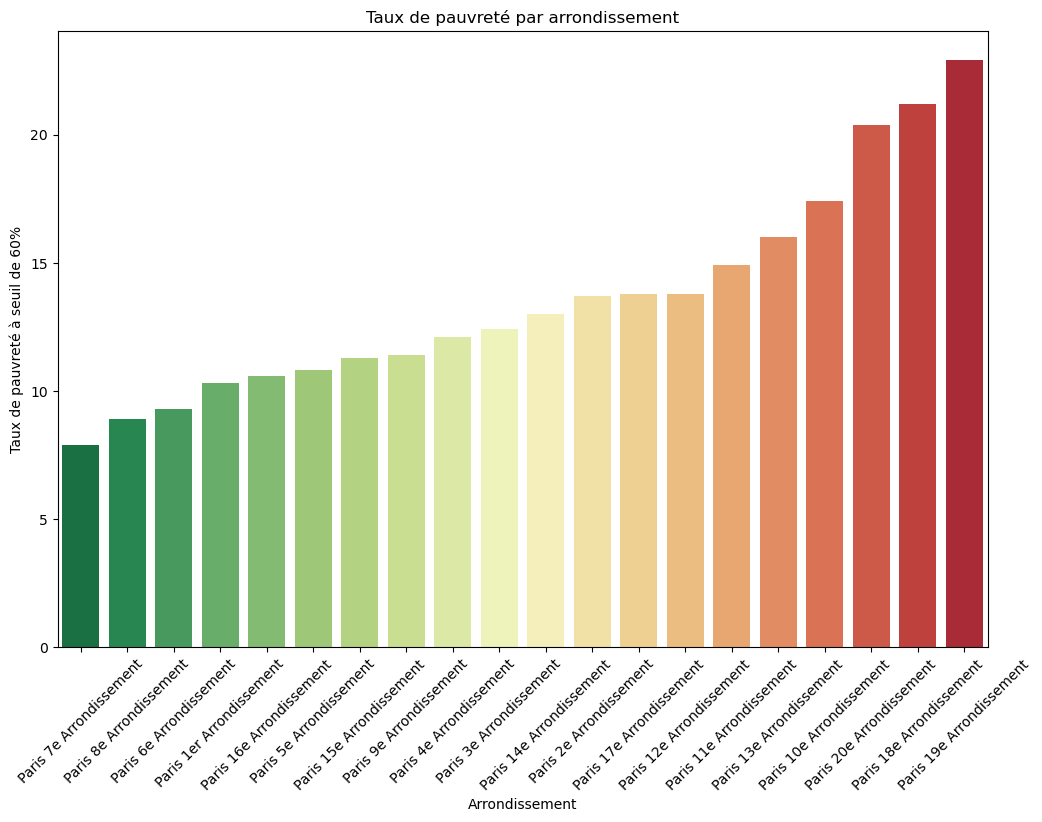

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pauv_sorted = df_pauv_flt.sort_values('TP6017')
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='LIBGEO', y='TP6017', data=df_pauv_sorted, palette='RdYlGn_r')
plt.title('Taux de pauvreté par arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Taux de pauvreté à seuil de 60%')
plt.xticks(rotation=45)

plt.show()


## Importation d'une base sur les logements sociaux à Paris

In [25]:
import requests

url_api_pauv = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/logements-sociaux-finances-a-paris/exports/json?select=code_postal,bs,nb_logmt_total,geo_shape"

try:
    response = requests.get(url_api_pauv)
    response.raise_for_status()
    wb = response.json()
except requests.exceptions.RequestException as e:
    print(f"Erreur lors de la requête : {e}")
except ValueError:
    print("Erreur : Impossible de décoder le JSON.")


df_log = pd.DataFrame(wb)
df_log = df_log.rename(columns={
    'code_postal': 'INSEE_COG',
})
df_log.head()

,INSEE_COG,bs,nb_logmt_total,geo_shape
0,75011,ELOGIE SIEMP,15,"{'type': 'Feature', 'geometry': {'coordinates'..."
1,75020,RES.URB.,52,"{'type': 'Feature', 'geometry': {'coordinates'..."
2,75003,1001 VIES HABITAT,16,"{'type': 'Feature', 'geometry': {'coordinates'..."
3,75009,FREHA,12,"{'type': 'Feature', 'geometry': {'coordinates'..."
4,75012,ELOGIE SIEMP,42,"{'type': 'Feature', 'geometry': {'coordinates'..."


## Statistiques descriptives

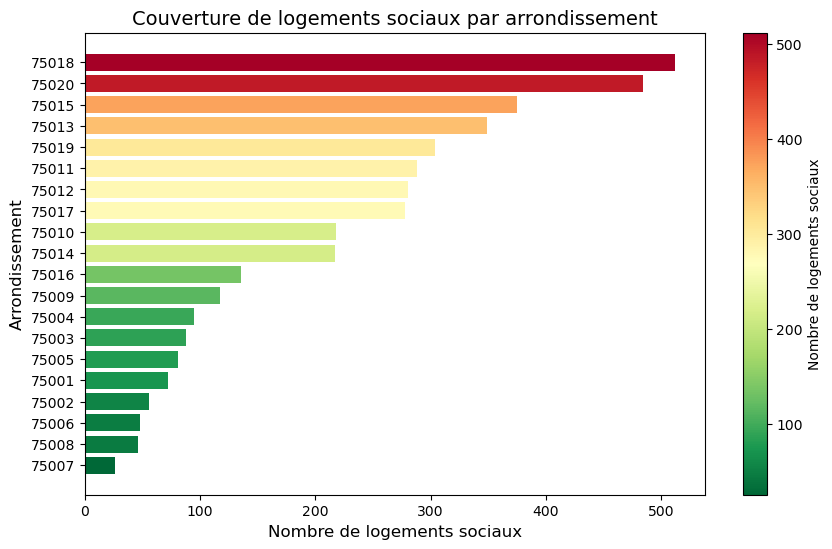

In [26]:
import matplotlib.colors as mcolors


nb_log = df_log['INSEE_COG'].value_counts()
nb_log_sorted = nb_log.sort_values()
norm = mcolors.Normalize(vmin=nb_log_sorted.min(), vmax=nb_log_sorted.max())
cmap = plt.cm.RdYlGn_r
colors = [cmap(norm(value)) for value in nb_log_sorted]
plt.figure(figsize=(10, 6))
plt.barh(nb_log_sorted.index, nb_log_sorted.values, color=colors)
plt.xlabel("Nombre de logements sociaux", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Couverture de logements sociaux par arrondissement", fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Nombre de logements sociaux")
plt.show()

In [22]:
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import display

df_log['geometry'] = df_log['geo_shape'].apply(lambda x: Point(x['geometry']['coordinates']))
gdf_log = gpd.GeoDataFrame(df_log, geometry='geometry', crs="EPSG:4326")

m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
for _, row in gdf_log.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=0.5,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

display(m)
